In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque
from datetime import datetime
from decimal import Decimal
from enum import Enum
from itertools import cycle
from math import floor
import numpy as np
import pandas as pd
from random import randrange, seed
from os.path import join

from pprint import pprint

import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/bhsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [84]:
#path = '/home/b3arjuden/crocket/sql_data/PRODUCTION40'

path = '/Users/bhsu/crypto/sql_data/PRODUCTION40'

file = 'BTC-ETH.csv'

In [85]:
file_path = join(path, file)

data = pd.read_csv(file_path, 
                   dtype={'time': str, 'buy_order': int, 'sell_order': int},
                   converters={'price': Decimal,
                               'wprice': Decimal,
                               'base_volume': Decimal,
                               'buy_volume': Decimal,
                               'sell_volume': Decimal})

In [4]:
def time_transform(df, n):
    
    df1 = pd.DataFrame()
    
    nrows = n * floor(df.shape[0] / n)
    df = df.iloc[:nrows, :]
    
    df1['time'] = df.loc[df.index[::n], 'time'].reset_index(drop=True)
    df1['open'] = (df.loc[::n, 'wprice'].values)
    df1['high'] = (df.loc[:, 'wprice'].groupby(df.index // n).max()) # TODO: estimate using 2 standard deviation from mean
    df1['low'] = (df.loc[:, 'wprice'].groupby(df.index // n).min()) # TODO: estimate using 2 standard deciation from mean 
    df1['close'] = (df.loc[(n-1)::n, 'wprice'].values)
    
    df1['buy_volume'] = df.loc[:, 'buy_volume'].groupby(df.index // n).sum()
    df1['sell_volume'] = df.loc[:, 'sell_volume'].groupby(df.index // n).sum()
    df1['buy_order'] = df.loc[:, 'buy_order'].groupby(df.index // n).sum()
    df1['sell_order'] = df.loc[:, 'sell_order'].groupby(df.index // n).sum()
    
    #df1['wprice'] = ((df.loc[:, 'wprice'] * df.loc[:, 'base_volume']).groupby(df.index // n).sum() / 
    #                 df.loc[:, 'base_volume'].groupby(df.index // n).sum()).apply(lambda x: float(x.quantize(Decimal(10) ** -8)))
    
    return df1

def vectorize(array):
    
    return np.transpose(array).reshape(1, array.size)

def unvectorize(vector, x, y):
    
    return vector.reshape(x, y)

In [5]:
class NeuralNetwork:
    
    def __init__(self, 
                 num_actions,
                 checkpoint_path=None):
        
        self.checkpoint_path = checkpoint_path
        
        self.count_states = 0
        self.count_episodes = 0
    
    def build(self):
        
        model = Sequential()
#         model.add(Dense(units=120, input_dim=64, activation='relu'))
#         model.add(Dense(units=60, activation='relu'))
#         model.add(Dense(units=20, activation='relu'))
#         model.add(Dense(units=3, activation='softmax'))

        model.add(Dense(units=12, input_dim=9, activation='relu'))
        model.add(Dense(units=3, activation='softmax'))
        
        # Optimizer: adam, RMSProp
        model.compile(optimizer='adam', loss='mse')
        
        self.model = model
    
    def save(self):
        
        save_file = 'network_S{}_E{}.h5'.format(self.count_states, self.count_episodes)
        model.save(join(self.checkpoint_path, save_file))
    
    def load(self, model_path):
        
        self.model = load_model(model_path)
        
        # TODO: load count_states and count_episodes from file
    
    def get_weights(self):
        
        return [layer.get_weights() for layer in self.model.layers]
    
    def set_weights(self, weights):
        
        for layer, new_weights in zip(self.model.layers, weights):
            layer.set_weights(new_weights)
    
    def interpolate_weights(self, weights, interpolation_factor=0.001):
        
        for layer, new_weights in zip(self.model.layers, weights):
            layer.set_weights([w1 * interpolation_factor + (1 - interpolation_factor) * w0 for w0, w1 in zip(layer.get_weights(), new_weights)])
    
    # TODO: add initialization function?

In [6]:
class Agent:
    """
    Rules:
    - Position = 0 -> HOLD, BUY
    - Position => 1 -> HOLD, SELL
    """
    
    def __init__(self, parameters):
        
        self.num_actions = parameters.num_actions
        self.discount_factor = parameters.discount_factor
        self.epsilon = parameters.epsilon
        self.epsilon_min = parameters.epsilon_min
        self.epsilon_decay = parameters.epsilon_decay
        self.priority_epsilon = parameters.priority_epsilon
        self.priority_alpha = parameters.priority_alpha
        self.batch_size = parameters.batch_size
        
        self._initialize()
        
    def _initialize(self, model_path=None):
        
        self.train_model = NeuralNetwork(num_actions=self.num_actions)
        self.target_model = NeuralNetwork(num_actions=self.num_actions)
        
        if model_path:
            pass
            # TODO: implement load model from folder (network_weights, replay_memory, additional_params)
        else:
            self.replay_memory = ReplayMemory(memory_size=parameters.replay_memory_size,
                                              state_shape=parameters.state_length,
                                              num_actions = self.num_actions,
                                              discount_factor=self.discount_factor)
            
            self.train_model.build()
            self.target_model.build()
            
            self.target_model.set_weights(self.train_model.get_weights())
        
    def act(self, state):
        
        # no position -> actions allowed: HOLD, BUY
        # active position -> HOLD, BUY, SELL
        
        buy_price = state[0, -1]
        
        if buy_price == 0:
            actions = [0, 1]
        else:
            actions = [0, 2]
            
        if np.random.rand() < self.epsilon:
            return actions[np.random.randint(2)]
        
        values = self.train_model.model.predict(state)
        
        return actions[np.argmax(values[0][actions])]
    
    def replay(self):
        
        samples = self.replay_memory.random_batch(self.batch_size)
        states_batch, action_batch, reward_batch, next_states_batch, indexes = map(np.array, samples)

        q_values_next = self.train_model.model.predict(next_states_batch)
        best_actions = np.argmax(q_values_next, axis=1)
        q_values_next_target = self.target_model.model.predict(next_states_batch)
        
        # SELL equivalent to end of episode
        targets_batch = reward_batch + \
            (action_batch != 2).astype(int) * (self.discount_factor * np.repeat(q_values_next_target[np.arange(self.batch_size), best_actions].reshape(self.batch_size, 1), self.num_actions, axis=1))
        
        targets_batch = targets_batch * np.stack([[1, 1, 0] if x[-1] == 0 else [1, 0, 1] for x in states_batch])
        
        # TODO: clip reward
        
        # Update transition probabilities before updating training model parameters
        self.update_transition_probabilities(states_batch, actions_batch, rewards_batch, targets_batch, indexes)
        
        # Update train model
        self.train_model.model.fit(states_batch, targets_batch)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def initialize_replay_memory(self, env, parameters, price_index):
        
        print('Initializing replay memory...')
        
        state = env.reset()
        
        for i in range(parameters.replay_memory_size):

            action = self.act(state)
            next_state, reward, _ = env.step(action, price_index)
            self.replay_memory.add(state, action, reward, next_state, 1)
            state = next_state
            
        print('Replay memory initialized.')
        
    def update_transition_priorities(self, states_batch, actions_batch, rewards_batch, targets_batch, indexes):
        
        for s0, a, r, t, i in zip(states_batch, actions_batch, rewards_batch, targets_batch, indexes):
            
            priority = (abs(self.train_model.model.predict(s0)[a] - t[a]) + self.priority_epsilon) ** self.priority_alpha

In [18]:
samples = agent.replay_memory.random_batch(agent.batch_size)

In [31]:
samples[0]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.69329860e-02,   1.06883144e-01,   1.17258680e-01,
          1.28048367e-01,   1.39240531e-01,   1.50823061e-01,
          1.62783423e-01,   1.75108676e-01,   1.82846588e-02],
       [  4.86194703e-03,   7.42161107e-03,   1.05142775e-02,
          1.41366000e-02,   1.82846588e-02,   2.29539655e-02,
          2.81394676e-02,   3.38355540e-02,   1.82846588e-02],
       [  5.00000000e-01,   4.83554281e-01,   4.67126358e-01,
          4.50734006e-01,   4.34394963e-01,   4.18126909e-01,
          4.01947447e-01,   3.85874085e-01,   0.00000000e+00],
       [  6.92297570e-01,   6.77012639e-01,   6.61536169e-01,
          6.45884906e-01,   6.30075786e-01,   6.14125915e-01,
          5.98052553e-01,   5.81873091e-01,   0.00000000e+00],
       [  1.68901262e-01,   1.56756812e-01,   1.44983774e-01,
   

In [28]:
samples[0][0].shape[0]

9

In [32]:
[x for x in agent.replay_memory.states if x[0] == 0]

[array([ 0.        ,  0.00040577,  0.00135213,  0.00283806,  0.00486195,
         0.00742161,  0.01051428,  0.0141366 ,  0.        ])]

In [33]:
class ReplayMemory:
    
    # TODO: implement prioritized state-action values
        
    def __init__(self, memory_size, state_shape, num_actions, discount_factor):
        
        self.memory_size = memory_size
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.discount_factor = discount_factor
        
        self.states = np.zeros(shape=[memory_size] + state_shape, dtype=np.float64)
        self.states_next = np.zeros(shape=[memory_size] + state_shape, dtype=np.float64)
        self.actions = np.zeros(shape=[memory_size, num_actions], dtype=np.int8)
        self.rewards = np.zeros(shape=[memory_size, num_actions], dtype=np.float64)
        self.priorities = np.ones(shape=[memory_size], dtype=np.float64)
        
        self.indexes = cycle(range(memory_size))
        self.pointer = next(self.indexes)
        
    def add(self, state, action, reward, next_state, priority):
        
        k = self.pointer

        self.states[k, :] = state
        self.actions[k] = action
        self.rewards[k] = reward  # TODO: consider clipping
        self.states_next[k, :] = next_state
        self.priorities[k] = priority
        
        self.pointer = next(self.indexes)
        
    def random_batch(self, batch_size):
        
        idx = np.random.randint(self.memory_size, size=batch_size)
        
        return self.states[idx], self.actions[idx], self.rewards[idx], self.states_next[idx], idx
    
    def calculate_probability(self, state, action, reward, next_state, ):
        
        pass
        

In [8]:
class Environment:
    
    def __init__(self,
                 input_data,
                 steps=None):
        
        self.steps = steps
        self._load(input_data)
        
        self.episode = {}
        
    def _load(self, input_data):
        
        self.data = input_data
        
        self.shape = input_data.shape
        
        if self.steps is None or self.steps > self.shape[0]:
            self.steps = self.shape[0] - 1
    
    def _seed(self):
        
        seed()
        
    def reset(self):
        
        self._seed()
        self.episode['start'] = 0
        self.episode['current_index'] = self.episode.get('start')
        self.data[:, :, -1] = 0  # Reset buy state
        
        return self.data[self.episode.get('current_index')]
        
    def step(self, action, price_index):
        
        current_index = self.episode.get('current_index')
        state = self.data[current_index]
        next_state = self.data[current_index + 1]

        price = state[0, price_index]
        buy_price = state[0, -1]
        
        if action == 1:
            next_state[0, -1] = price
            reward = [0, price * -2, 0]
        elif action == 2:
            next_state[0, -1] = 0
            margin = price / buy_price
            reward = [0, 0, (margin if margin > 1 else -margin) * 2]
        else:
            # TODO: set reward to difference between buy_price and current_price if position held, but smaller magnitude than buying or selling
            next_state[0, -1] = buy_price
            reward = [0, 0, 0]
        
        self.episode['current_index'] += 1
        
        return next_state, reward, current_index 
        
    def start_new_episode(self):
        
        self.episode['start'] = np.random.randint(0, self.shape[0] - self.steps)
        self.episode['current_index'] = self.episode.get('start')
        
        return self.data[self.episode.get('current_index')]

In [9]:
class Action(Enum):

    HOLD = 0
    BUY = 1
    SELL = 2

In [10]:
class Summary:
    
    def __init__(self, parameters=None):
        
        self.episodes = []
        self.params = parameters
        
    def create(self, actions, train_reward, actual_reward, start, end, epsilon_end):
        
        # TODO: add epsilon values
        
        self.episodes.append({
            'actions': actions,
            'train_reward': train_reward,
            'actual_reward': actual_reward,
            'start': start,
            'end': end,
            'epsilon_end': epsilon_end
        })
        
    def summarize_all(self):
        
        num_episodes = len(self.episodes)
        train_reward = np.zeros(num_episodes)
        actual_reward = np.zeros(num_episodes)
        epsilon_end = np.zeros(num_episodes)
        
        for ii in range(num_episodes):
            train_reward[ii], actual_reward[ii], epsilon_end[ii] = (self.episodes[ii][x] for x in ['train_reward', 'actual_reward', 'epsilon_end'])
        
        # TODO: add plot here
        
        return train_reward, actual_reward, epsilon_end
    
    def summarize_episode(self, episode_num):
        
        episode_summary = self.episodes[episode_num]
        
        return episode_summary
    
    def get_price(self, price, episode_num):
        
        start = self.episodes[episode_num].get('start')
        end = self.episodes[episode_num].get('end')
        
        return price[start:end]

In [11]:
# Data processing parameters
n = 15
m = 8

In [12]:
# Test data
x = np.linspace(-np.pi, np.pi, 192)
array = np.sin(x)

price_state_index = -2

min_max_scaler = preprocessing.MinMaxScaler()
normalized_array = min_max_scaler.fit_transform(array.reshape(-1, 1))

# Build states
states = np.array([vectorize(normalized_array[x:x+m, :]) for x in range(normalized_array.shape[0] - m + 1)])

# Add state for position held
states = np.insert(states, states.shape[2], 0, axis=2)

# Build prices
prices = list(map(float, array[(m-1):]))

In [16]:
# Combine data
df = time_transform(data.iloc[:200*15,:], n)
array = df.iloc[:,1:].as_matrix()

# Get close price column index
price_df_index = df.columns.get_loc('close')
price_array_index = price_df_index-1
price_state_index = m*(price_array_index+1)-1

In [17]:
# Normalize data 
# TODO: change normalization if necessary
min_max_scaler = preprocessing.MinMaxScaler()
normalized_array = min_max_scaler.fit_transform(array)

/Users/bhsu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [53]:
# Build states
states = np.array([vectorize(normalized_array[x:x+m, :]) for x in range(normalized_array.shape[0] - m + 1)])

# Add state for position
states = np.insert(states, states.shape[2], 0, axis=2)

# Build prices
prices = list(map(float, array[(m-1):, price_array_index]))

IndexError: too many indices for array

In [25]:
len(states), len(prices)

(185, 185)

In [13]:
class Parameters:
    
    def __init__(self):
        
        # Time series parameters
        self.num_actions = 3
        
        # Neural network parameters
        self.discount_factor = 0.97
        self.epsilon = 0.99
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        
        # Replay memory parameters
        self.replay_memory_size = 184
        self.batch_size = 100
        self.priority_epsilon = 0.1
        self.priority_alpha = 2
        
        # Training parameters
        self.episodes = 100
        self.episode_length = 184
        self.update_target_weights_step_size = 100
        self.train_model_step_size = 100
        self.interpolation_factor = 0.1

In [16]:
## Model training

parameters = Parameters()
parameters.state_length = [states.shape[-1]]
agent = Agent(parameters)
env = Environment(states, steps=parameters.episode_length)
summary = Summary()
step = 0

# Populate the replay memory with initial experiences
agent.initialize_replay_memory(env, parameters, price_index=price_state_index)

for e in range(parameters.episodes):
    
    state = env.start_new_episode()
    
    episode_learn_reward = 0
    episode_actions = np.zeros(parameters.episode_length)
    episode_actual_reward = 0
    
    for ii in range(parameters.episode_length):
        
        # Update the target network weights every X iterations
        if step % parameters.update_target_weights_step_size == 0:
            print('Step {}: Updating target Q network weights with latest Q network weights.'.format(step))
            agent.target_model.interpolate_weights(agent.train_model.get_weights(), parameters.interpolation_factor)
                
        action = agent.act(state)
        next_state, reward, index = env.step(action, price_index=price_state_index)
        agent.replay_memory.add(state, action, reward, next_state, 1)
        state = next_state
        
        episode_actions[ii] = action
        episode_learn_reward += reward[action]
        
        if action > 0:
            price = prices[index]
            episode_actual_reward += price * -1.0025 if action == 1 else price * 0.9975
        
        if step % parameters.train_model_step_size == 0:
            print('Step {}: Sampling replay memory and training Q network.'.format(step))
            
            agent.replay()
            
        step += 1
    
    summary.create(episode_actions, episode_learn_reward, episode_actual_reward, env.episode.get('start'), env.episode.get('current_index')+1, agent.epsilon)

Initializing replay memory...
Replay memory initialized.
Step 0: Updating target Q network weights with latest Q network weights.
Step 0: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 2ms/step - loss: 0.6910
Step 100: Updating target Q network weights with latest Q network weights.
Step 100: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 90us/step - loss: 0.5865
Step 200: Updating target Q network weights with latest Q network weights.
Step 200: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 138us/step - loss: 2.3474
Step 300: Updating target Q network weights with latest Q network weights.
Step 300: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 118us/step - loss: 0.6265
Step 400: Updating target Q network weights with latest Q network weights.
Step 400: Sampling 

100/100 [==============================] - 0s 76us/step - loss: 0.1694
Step 3800: Updating target Q network weights with latest Q network weights.
Step 3800: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 93us/step - loss: 0.2375
Step 3900: Updating target Q network weights with latest Q network weights.
Step 3900: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 61us/step - loss: 0.3108
Step 4000: Updating target Q network weights with latest Q network weights.
Step 4000: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 96us/step - loss: 0.2381
Step 4100: Updating target Q network weights with latest Q network weights.
Step 4100: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 93us/step - loss: 0.2639
Step 4200: Updating target Q network weights with latest Q network we

100/100 [==============================] - 0s 134us/step - loss: 0.2395
Step 7600: Updating target Q network weights with latest Q network weights.
Step 7600: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.2012
Step 7700: Updating target Q network weights with latest Q network weights.
Step 7700: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 101us/step - loss: 0.0752
Step 7800: Updating target Q network weights with latest Q network weights.
Step 7800: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.3313
Step 7900: Updating target Q network weights with latest Q network weights.
Step 7900: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 209us/step - loss: 0.3138
Step 8000: Updating target Q network weights with latest Q netwo

100/100 [==============================] - 0s 185us/step - loss: 0.0647
Step 11400: Updating target Q network weights with latest Q network weights.
Step 11400: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0484
Step 11500: Updating target Q network weights with latest Q network weights.
Step 11500: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 65us/step - loss: 1568.7296
Step 11600: Updating target Q network weights with latest Q network weights.
Step 11600: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 92us/step - loss: 0.1449
Step 11700: Updating target Q network weights with latest Q network weights.
Step 11700: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 68us/step - loss: 0.0903
Step 11800: Updating target Q network weights with lates

100/100 [==============================] - 0s 72us/step - loss: 0.1400
Step 15200: Updating target Q network weights with latest Q network weights.
Step 15200: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 205us/step - loss: 0.0901
Step 15300: Updating target Q network weights with latest Q network weights.
Step 15300: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 91us/step - loss: 0.2515
Step 15400: Updating target Q network weights with latest Q network weights.
Step 15400: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 219us/step - loss: 0.1284
Step 15500: Updating target Q network weights with latest Q network weights.
Step 15500: Sampling replay memory and training Q network.
Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.2146
Step 15600: Updating target Q network weights with latest 

Training reward: -5.413289330448461
Actual reward: -0.3044028020855554


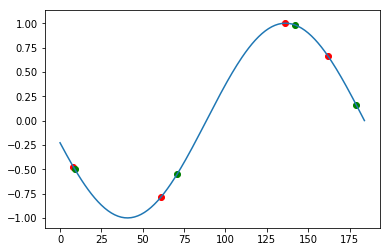

In [29]:
# Examine episode

episode_num = 98

episode_summary = summary.summarize_episode(episode_num)
episode_price = summary.get_price(prices, episode_num)
actions = episode_summary.get('actions')

print('Training reward: {}'.format(episode_summary.get('train_reward')))
print('Actual reward: {}'.format(episode_summary.get('actual_reward')))

# Plot graph of buy/sell actions
buy_indices = [x for x in range(len(actions)) if actions[x] == 1]
buy_prices = [episode_price[x] for x in buy_indices]

sell_indices = [x for x in range(len(actions)) if actions[x] == 2]
sell_prices = [episode_price[x] for x in sell_indices]

plt.plot(episode_price)
plt.scatter(buy_indices, buy_prices, color='r')
plt.scatter(sell_indices, sell_prices, color='g')

In [35]:
agent.replay_memory.rewards

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.70823019,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.88534386],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [30]:
train, actual, epsilon = summary.summarize_all()

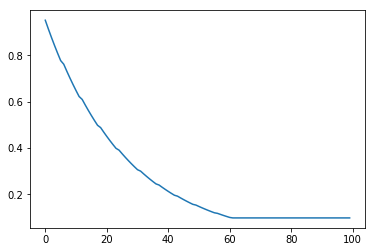

In [33]:
plt.plot(epsilon)